#### Goal: Simulate a vrms map with Jampy axi rms.

For this, we are using a MGE light decomposition of SDP.81 (already in proper units, and stored in JAM_Input.txt).

Beside that, we include a NFW profile for dark matter (stored in SphNFW_2e3arcsec.txt with kappa_s equal to one, but we change it during the simulation).

We are using a MUSE psf.
Attention to sigmapsf, it is in pixel, not in arcsec.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from plotbin.plot_velfield import plot_velfield
from My_Jampy import JAM                          #My class for jampy

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/Autolens_tests/autolens_workspace/Test_3/Simulation_data/"

In [2]:
#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("JAM_Input.txt", unpack=True)      #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("SphNFW_2e3arcsec.txt", unpack=True)     #DM component
norm_psf, sigma_psf           = np.loadtxt("MUSE_Psf_model.txt", unpack=True) #PSF

### Input parameters

In [3]:
z_l    = 0.299                                            #Redshift
D_l    = cosmo.angular_diameter_distance(z_l).value                    #Distance to Lens [Mpc] 
mbh    = 1e9                                                           #mass of black hole [log10(M_sun)]
beta   = np.full_like(surf_lum, 0.35)                                 #anisotropy [ad]
inc    = 60                                                            #inclination [deg]
kappa_s = 0.075                                                        #kappa_s of DM profile
ml     = 5.00                                                          #mass to light ratio

pixsize = 0.2    #MUSE pixel size


In [4]:
#Grid with xbin and ybin position (in px)
np.random.seed(123)
xbin, ybin = np.random.uniform(low=[-20, -15], high=[20, 15], size=[300, 2]).T

In [5]:
#Now we start our Jampy class
Jam_model = JAM(ybin=ybin*pixsize, xbin=xbin*pixsize, inc=inc, distance=D_l, mbh=mbh, beta=beta,
                   normpsf=norm_psf, sigmapsf=sigma_psf*pixsize, pixsize=pixsize)

#Add Luminosity component
Jam_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                    qobs_lum=qobs_lum, ml=ml)
#Add DM component
Jam_model.DM_component(surf_dm=kappa_s * surf_dm, sigma_dm=sigma_dm, qobs_dm=qobs_dm)

In [6]:
#Run my Jam class
plt.figure(figsize=(12,12))
My_model, ml = Jam_model.run_simulation(plot=True, quiet=False, cmap="sauron",nodots=False)


jam_axi_rms elapsed time sec: 0.93


<Figure size 864x864 with 0 Axes>

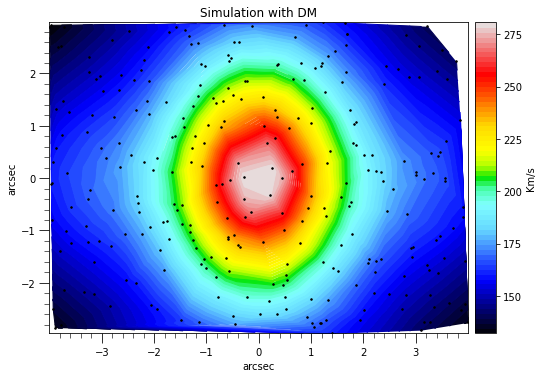

In [7]:
plt.figure(figsize=(8,6))
plot_velfield(x=xbin*pixsize, y=ybin*pixsize, vel=My_model, colorbar=True, label="Km/s")
plt.title("Simulation with DM")
plt.xlabel("arcsec")
plt.ylabel("arcsec")



plt.savefig(data_folder+"Vrms_Map_without noise.png", fmt="png")

In [8]:
#Add some gaussian noise in Vrms map
noisy_vrms = My_model - 10 * np.random.randn(300)

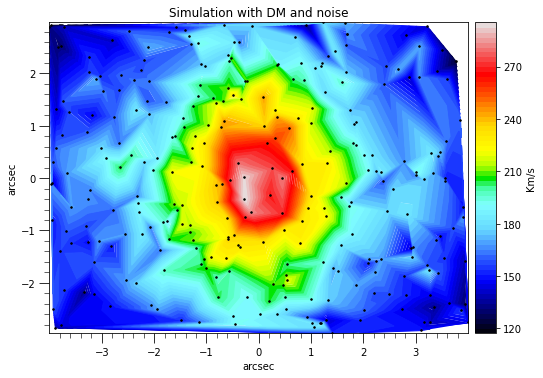

In [9]:
plt.figure(figsize=(8,6))
plot_velfield(x=xbin*pixsize, y=ybin*pixsize,vel=noisy_vrms, colorbar=True, label="Km/s")
plt.title("Simulation with DM and noise")
plt.xlabel("arcsec")
plt.ylabel("arcsec")



plt.savefig(data_folder+"Vrms_Map_noisy.png", fmt="png")

Text(0, 0.5, 'arcsec')

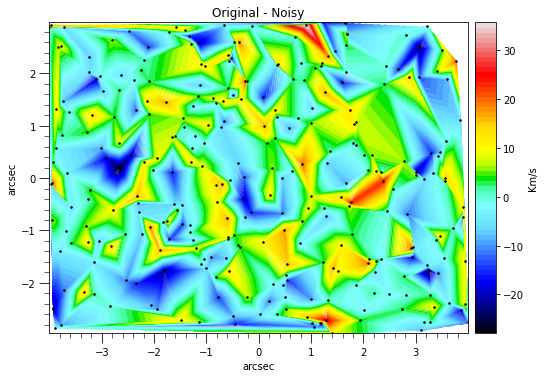

In [10]:
plt.figure(figsize=(8,6))
plot_velfield(x=xbin*pixsize, y=ybin*pixsize,vel=My_model-noisy_vrms, colorbar=True, label="Km/s")
plt.title("Original - Noisy")
plt.xlabel("arcsec")
plt.ylabel("arcsec")

In [11]:
np.savetxt(data_folder+"vrms_data.txt", np.column_stack([xbin, ybin, noisy_vrms]),
                          fmt=b'%.5e \t %.5e \t %.5e', 
                            header="xbin [px] \t ybin [px] \t vrms [Km/s]")

------------------------------------------------------------------------------------------------------------------

### Recovery test

In [12]:
x, y, vrms = np.loadtxt(data_folder+"vrms_data.txt", unpack=True)                  #vrms data
surf_lum, sigma_lum, qobs_lum = np.loadtxt("JAM_Input.txt", unpack=True)           #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("SphNFW_2e3arcsec.txt", unpack=True)     #DM component
norm_psf, sigma_psf           = np.loadtxt("MUSE_Psf_model.txt", unpack=True)      #PSF

In [13]:
#Input
z_l    = 0.299                                            #Redshift
D_l    = cosmo.angular_diameter_distance(z_l).value                    #Distance to Lens [Mpc] 
mbh    = 1e9                                                           #mass of black hole [log10(M_sun)]
beta   = np.full_like(surf_lum, 0.35)                                 #anisotropy [ad]
inc    = 60                                                            #inclination [deg]
kappa_s = 0.075                                                        #kappa_s of DM profile
ml     = 5.0                                                          #mass to light ratio

pixsize = 0.2    #MUSE pixel size


In [14]:
#Now we start our Jampy class
Jam_model = JAM(ybin=y*pixsize, xbin=x*pixsize, inc=inc, distance=D_l, mbh=mbh, beta=beta, rms=vrms,
                   normpsf=norm_psf, sigmapsf=sigma_psf*pixsize, pixsize=pixsize)

#Add Luminosity component
Jam_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                    qobs_lum=qobs_lum, ml=ml)
#Add DM component
Jam_model.DM_component(surf_dm=kappa_s * surf_dm, sigma_dm=sigma_dm, qobs_dm=qobs_dm)

jam_axi_rms elapsed time sec: 0.65
inc=60.0 beta_z=0.35 M/L=1 BH=1.00e+09 chi2/DOF=1.34
Total mass MGE: 9.682e+12


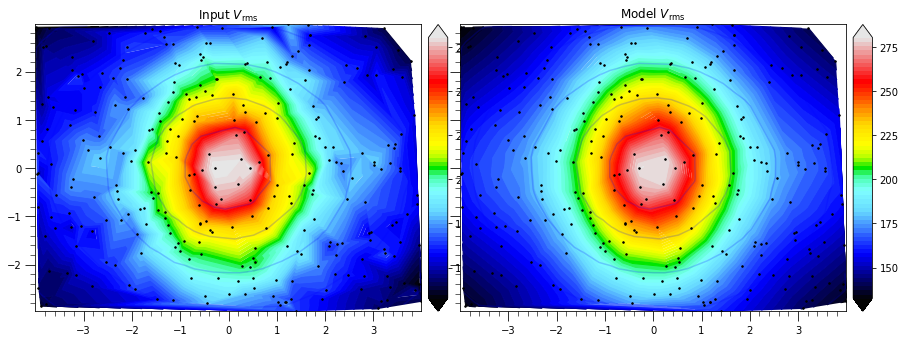

In [15]:
#Run my Jam class
plt.figure(figsize=(15,15))
My_model, ml, chi2, chi2T = Jam_model.run(plot=True, quiet=False, cmap="sauron",nodots=False)